<h1 align="center">Small Dataset Text Classification in Keras</h1>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Getting the Data

In [2]:
data = pd.read_csv('imdb_labelled.txt', sep='\|', engine='python', header=None)
data.columns = ['text', 'label']

In [3]:
data.head()

,text,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


# Distribution of Labels

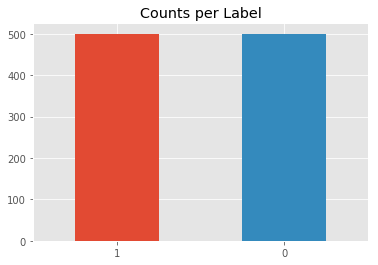

In [4]:
ax = data.label.value_counts().plot(kind='bar', rot=0, title='Counts per Label')

# Preprocessing

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stopwords = set(stopwords.words('english'))
from nltk.tokenize import RegexpTokenizer

def remove_stopwords(sent):
    words = word_tokenize(sent)
    return ' '.join([w for w in words if w not in stopwords])   
    
def remove_punctuations(sent):
    regex_tok = RegexpTokenizer(r'\w+')
    words = regex_tok.tokenize(sent)
    return ' '.join(words)

def preprocess_sent(sent):
    sent = sent.lower()
    return remove_punctuations(remove_stopwords(sent))

preprocessed_text = data.text.apply(preprocess_sent)
data.loc[:, 'text'] = preprocessed_text

In [6]:
data.head()

,text,label
0,slow moving aimless movie distressed drifting ...,0
1,sure lost flat characters audience nearly half...,0
2,attempting artiness black white clever camera ...,0
3,little music anything speak,0
4,best scene movie gerardo trying find song keep...,1


## Train-test Split

In [7]:
test_df = data.groupby('label').apply(lambda g: g.sample(frac=0.2, random_state=1000))
test_df.index = test_df.index.droplevel(0)
train_df = data.drop(test_df.index, axis=0)
print("Train and test lengths: ", len(train_df), len(test_df))

Train and test lengths:  800 200


# Text Classification In Keras

First we assign a unique id to each word and then replace each sentence as a list of word ids. Then we pad / clip each sentence to be of a max length (say 15).

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

vocab_size = 40000
tokenizer = Tokenizer(lower=True, num_words=vocab_size)
tokenizer.fit_on_texts(train_df.text.values)
pad_len = 15

train_sequences = pad_sequences(tokenizer.texts_to_sequences(train_df.text.values), pad_len)
test_sequences = pad_sequences(tokenizer.texts_to_sequences(test_df.text.values), pad_len)

Using TensorFlow backend.


In [9]:
print("Shape of train sequences: ", train_sequences.shape)
print("Shape of test sequences : ", test_sequences.shape)

Shape of train sequences:  (800, 15)
Shape of test sequences :  (200, 15)


In [10]:
train_sequences[:5]

array([[  0,   0,   0,   0,   0,   0,   0, 193, 243, 887,   1, 888, 889,
        244,  59],
       [  0,   0,   0,   0,   0,   0,   0, 342, 245, 501,  16, 194, 890,
        156, 891],
       [343, 126, 502,   1, 503, 894,  15, 195,  10, 196,  22, 157, 111,
        246, 895],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  38,  85,
        127, 344],
       [  0,   0,   0,   0,   0,  29, 112,   1, 896, 345,  86, 346, 504,
        505, 347]])

# Model Construction

In [66]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM 
from keras.layers.embeddings import Embedding

embedding_size = 60

model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_size, mask_zero=True))
model.add(SimpleRNN(units=10, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 60)          2400060   
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 10)                710       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 11        
Total params: 2,400,781
Trainable params: 2,400,781
Non-trainable params: 0
_________________________________________________________________


# Training

In [68]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.008)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_sequences, train_df.label.values,
  batch_size=32,
  epochs=10,
  verbose=1,
  validation_split=0.1,
  shuffle=True)

Train on 720 samples, validate on 80 samples
Epoch 1/10
720/720 [==============================] - 3s 5ms/step - loss: 0.6982 - acc: 0.4472 - val_loss: 0.6817 - val_acc: 0.5625
Epoch 2/10
720/720 [==============================] - 1s 1ms/step - loss: 0.6967 - acc: 0.4694 - val_loss: 0.6817 - val_acc: 0.5625
Epoch 3/10
720/720 [==============================] - 1s 2ms/step - loss: 0.6952 - acc: 0.4764 - val_loss: 0.6804 - val_acc: 0.5875
Epoch 4/10
720/720 [==============================] - 1s 2ms/step - loss: 0.6939 - acc: 0.4806 - val_loss: 0.6800 - val_acc: 0.5875
Epoch 5/10
720/720 [==============================] - 1s 1ms/step - loss: 0.6925 - acc: 0.4931 - val_loss: 0.6802 - val_acc: 0.5750
Epoch 6/10
720/720 [==============================] - 1s 1ms/step - loss: 0.6911 - acc: 0.5139 - val_loss: 0.6799 - val_acc: 0.5750
Epoch 7/10
720/720 [==============================] - 1s 1ms/step - loss: 0.6898 - acc: 0.5236 - val_loss: 0.6810 - val_acc: 0.5500
Epoch 8/10
720/720 [===========

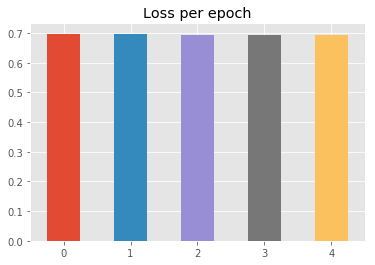

In [61]:
loss_per_epoch = history.history['loss']
ax = pd.Series(loss_per_epoch).plot(kind='bar', title='Loss per epoch', rot=0)

# Performance Analysis

In [73]:
predictions = model.predict(test_sequences).squeeze()
predictions = np.where(predictions > 0.5, 1, 0)

In [75]:
from sklearn.metrics import classification_report
report = classification_report(predictions, test_df.label.values)
print(report)

             precision    recall  f1-score   support

          0       0.64      0.52      0.57       123
          1       0.41      0.53      0.46        77

avg / total       0.55      0.53      0.53       200

